# Data visualisation

We start by importing the data

In [22]:
import sklearn
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm
import torch.utils.data as Data

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation 
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

#sklearn → model trening
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import accuracy_score

#sklearn → data treatment
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from ILSTM_Soil_model_main import lstm_interprety_soil_moisture as ILSTM
from My_tools import DataFileLoader as DFL # min egen

# path definitions

ROOT = "../../"

DATA_PATH = ROOT + "data/"

DATA_INFO = DATA_PATH + "info/"
DATA_INFO_NIBIO_FILE = DATA_INFO  + "lmt.nibio.csv"
DATA_INFO_FROST_FILE = DATA_INFO + "Frost_stations.csv"
DATA_INFO_NIBIO2FROST_FILE = DATA_INFO + "StationIDInfo.csv"
DATA_FILE_SOIL_STATIONS = DATA_INFO + "'Stasjonsliste jordtemperatur modellering.xlsx'"

DATA_COLLECTION = DATA_PATH + "raw_data/"
DATA_COLLECTION_STAT = DATA_COLLECTION + "Veret paa Aas 2013- 2017/" # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME = DATA_COLLECTION + "Time 2013- 2023/" # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO = DATA_COLLECTION + "nibio/" # pattern -> weather_data_hour_stID{id}_y{year}.csv
DATA_COLLECTION_MET = DATA_COLLECTION + "MET/" # pattern -> StationTo_{id}_FROM_{FrostID}.csv


# ID definitions

station_names = pd.read_csv(DATA_INFO_NIBIO_FILE,
                          header=0,
                          index_col = "ID")

nibio_data = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,"weather_data_hour_stID(\d{1,3})_y(\d{4}).csv")
nibio_data_missing = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,"weather_data_raw_hour_stID(\d{1,3})_y(\d{4}).csv")

nibio_data.load_data(names = ["Time","TM","RR","TJM10","TJM20"]) # Fra LMT
nibio_data_missing.load_data(names = ["Time","TM","RR","TJM10","TJM20"]) # Fra LMT

nibio_id = {
    "Innlandet" : [11,18,26,27],
    "Trøndelag" : [15,57,34,39],
    "Østfold" : [37,41,52,118],
    "Vestfold" : [30,38,42,50]
}

started load
ended load
started load
ended load


In [2]:
"""
        data_nibio_raw[!is.na(data_nibio_raw[,"TM"]) & (data_nibio_raw[,"TM"] <= 0),"RR"] <- NA 

        data_nibio[1:nrow(data_nibio_raw),"RR"] <- data_nibio_raw[1:nrow(data_nibio_raw),"RR"]
"""
def dataframe_merge_func(x,y):
    y.iloc[y.iloc[:,1].notna() & (y.iloc[:,1] <= 0),2] = pd.NA
    x.iloc[0:y.shape[0],2] = y.iloc[0:y.shape[0],2]
    return x


imputed_nibio_data = nibio_data.combine(nibio_data_missing,merge_func = dataframe_merge_func)

In [ ]:
# function definitions

import os.path

def show_plot(data,plot_kwarg):
    """
        plots timeseries, assumes dataframe with a 'Time' columns
    """
    for d in range(len(data)):
        if d not in plot_kwarg:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"])
        else:
            plt.plot(data[d].Time, data[d].iloc[:,data[d].columns != "Time"],**plot_kwarg[d])

def table2Latex(table, dir_path, file_name, header = "", append = False):
    if os.path.isfile(dir_path + file_name + ".tex") & append:
        file = open(dir_path+filename+".tex","a", encoding="utf-8")
    else:
        file = open(dir_path+filename+".tex","w", encoding="utf-8")

    file.write(r"\begin{tabular}{|l|" + ["c" for _ in range(len(header))].join("|") + "|}")
    if header != "":
        file.write(header.join("&") + r"\\\hline")
    for row in table:
        file.write(row.join("&") + r"\\\hline")
    file.write(r"\end{tabular}")

The data is splitted among two collections of data, one is a pdf and the other is a `.xlsx` format. We start by collecting the data from the hourly data collection.

In [4]:
"""
def traverse_iterative(d):
    stack = [(d, [])]  # Initialize the stack with the root dictionary and an empty path
    while stack:
        current_dict, path = stack.pop()
        for key, value in current_dict.items():
            new_path = path + [key]  # Extend the path
            if isinstance(value, dict):
                stack.append((value, new_path))  # Push nested dictionaries onto the stack
            else:
                print('_'.join(new_path), value)  # Print the path and value


def time_nibio():
    #global nibio_id #! need to change later.

    # flattening dict

    nibio_id_flat = []

    for vals in nibio_id.values():
        nibio_id_flat += vals
    
    data_dict = {
        R : {
            S: {
                y: pd.DataFrame() for y in range(2014,2020+1)
            } for S in nibio_id[R]
        } for R in nibio_id
    } 
    for reg in nibio_id:
        for id in nibio_id[reg]:
            for year in range(2014,2020+1):
                data = pd.read_csv(DATA_COLLECTION_NIBIO + "weather_data_hour_stID{}_y{}.csv".format(id,year),
                                   delimiter = ",",
                                   header = 0,
                                   parse_dates = True,
                                   names = ["Time", "TM","RR","TJM10","TJM20"])
                data["Time"] = pd.to_datetime(data["Time"] + "00",
                                              format = "%Y-%m-%d %H:%M:%S%z",
                                              utc=True)
                data_dict[reg][id][year] = data

    return data_dict
        

def time_nmbu():
    hourly_data_2013_2023 = {
        i : pd.DataFrame() for i in range(2013,2024)
    }
    for i in range(2016,2024): # starts from 2016 rather than 2013 due to difference in data quality
        raw_data = pd.read_excel(DATA_COLLECTION_TIME + "Time{}.xlsx".format(i)) # fetching data
        raw_data["DATO"] = pd.to_datetime(raw_data["DATO"], format="%d%m%y %H")
        raw_data = raw_data.set_index("DATO") # setting the date as index
        if len(set(["JT10","JT20","LT","NB"]).intersection(raw_data.columns)) == 4:
            hourly_data_2013_2023[i] = raw_data[["JT10","JT20","LT","NB"]] # selects only a few columns.
        else:
            print("WARNING: Table:" + str(i) + " has missing columns.\nMissing:" + str([ a for a in ["JT10","JT20","LT","NB"] if a not in raw_data.columns]))
    return hourly_data_2013_2023
"""

'\ndef traverse_iterative(d):\n    stack = [(d, [])]  # Initialize the stack with the root dictionary and an empty path\n    while stack:\n        current_dict, path = stack.pop()\n        for key, value in current_dict.items():\n            new_path = path + [key]  # Extend the path\n            if isinstance(value, dict):\n                stack.append((value, new_path))  # Push nested dictionaries onto the stack\n            else:\n                print(\'_\'.join(new_path), value)  # Print the path and value\n\n\ndef time_nibio():\n    #global nibio_id #! need to change later.\n\n    # flattening dict\n\n    nibio_id_flat = []\n\n    for vals in nibio_id.values():\n        nibio_id_flat += vals\n    \n    data_dict = {\n        R : {\n            S: {\n                y: pd.DataFrame() for y in range(2014,2020+1)\n            } for S in nibio_id[R]\n        } for R in nibio_id\n    } \n    for reg in nibio_id:\n        for id in nibio_id[reg]:\n            for year in range(2014,202

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


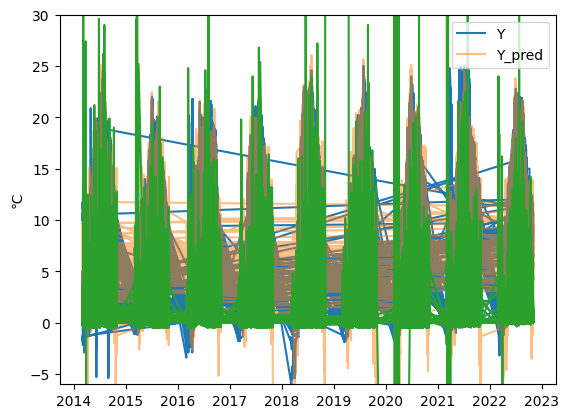

In [5]:
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
df = imputed_nibio_data.flatten()
data = df.dropna()
soil_decom = STL(data.loc[:,"TJM10"],period=22).fit()
air_decom = STL(data.loc[:,"TM"],period=24).fit()

plu_err = pd.DataFrame({"TM": air_decom.resid})
plu_trend = pd.DataFrame({ "TM": air_decom.trend})
plu_seson = pd.DataFrame({"TM": air_decom.seasonal})

lin_err = LinearRegression()
lin_trend = LinearRegression()
lin_seson = LinearRegression()

lin_err.fit(plu_err,soil_decom.resid)
lin_trend.fit(plu_trend,soil_decom.trend)
lin_seson.fit(plu_seson,soil_decom.seasonal)

pred_err = lin_err.predict(plu_err)
pred_trend = lin_trend.predict(plu_trend)
pred_seson = lin_seson.predict(plu_seson)

pred = pred_err + pred_trend + pred_seson

Y = pd.DataFrame(
    zip(data["Time"].to_numpy().tolist(), pred.flatten()),
    columns=["Time","Y_pred"])

show_plot([data.loc[:,["Time","TJM20"]],Y,data.loc[:,["Time","RR"]]],{1:{"alpha":0.5}} )
plt.legend(["Y","Y_pred"])
plt.ylim(-6,30)
plt.ylabel("℃")
plt.show()


## Linear regression function 

This function does a transformation of the $m\times n$ matrix (our dataframe) to a $m \times p$ matrix. This can be seen as a kernel trick where we transform the data to a more seperable state to improve prediction. The scema for this model is
$$
    (\vec{F}\circ \mathbf{A})\vec{\beta}=\vec{y}+\vec{\varepsilon})
$$

In [6]:
def F_plauborg(df: pd.DataFrame):
    """
        Fxn is based on a full year while df could have any range.
    """
    new_df = df.set_index("Time")

    data_ret = pd.DataFrame({"B0":new_df.loc[:,"TM"].values},columns = ["B"+str(i) for i in range(13)]+ ["FS" + str(i) for i in range(1,13)] + ["FC" + str(i) for i in range(1,13)])

    for i in range(1,13): # 1,2
        data_ret.loc[:,"B"+str(i)] = new_df.loc[:,"TM"].shift(i).values
        data_ret.loc[:,"FS"+str(i)] = np.sin(2*np.pi/(365*24) * ( new_df.index.day*24 + new_df.index.hour) * i)
        data_ret.loc[:,"FC"+str(i)] = np.cos(2*np.pi/(365*24) * ( new_df.index.day*24 + new_df.index.hour ) * i)

    return data_ret

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

region_score = dict()

#global_plaugborg = LinearRegression(n_jobs = -1)
#global_default = LinearRegression(n_jobs = -1)
df = imputed_nibio_data.merge_layer(level = 1)
#all_data_daily = concat_all(df).dropna().resample("D").mean()
#all_data = concat_all(df).dropna()

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


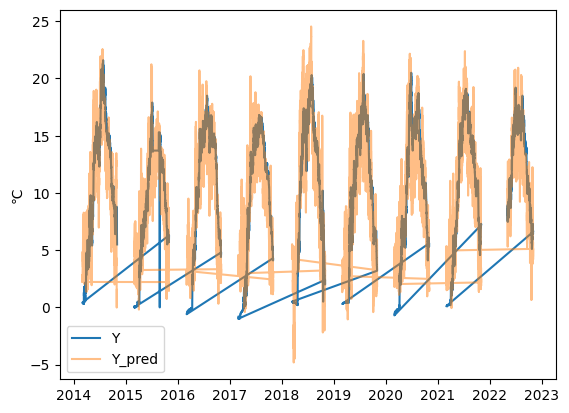

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


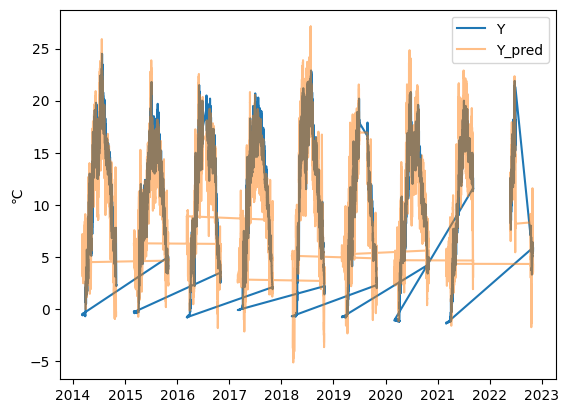

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


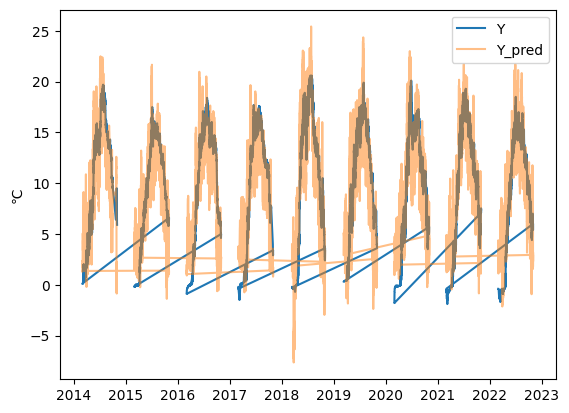

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


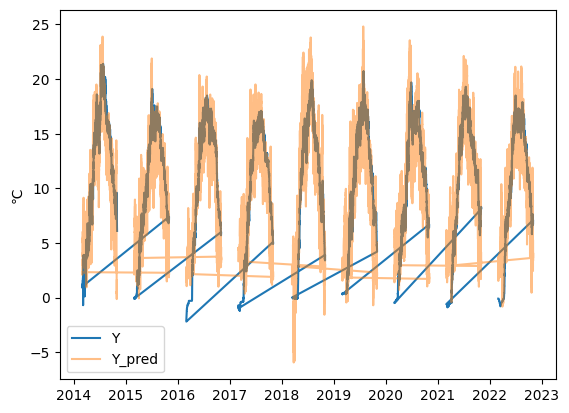

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


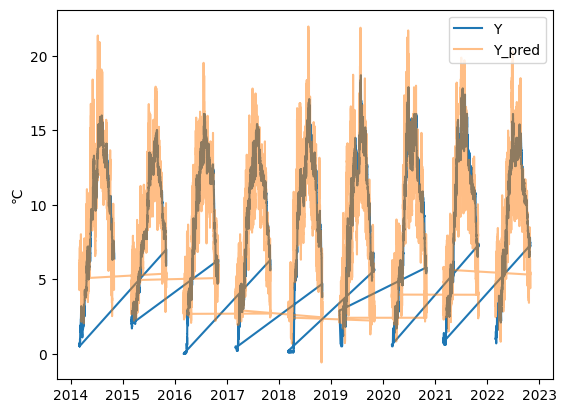

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


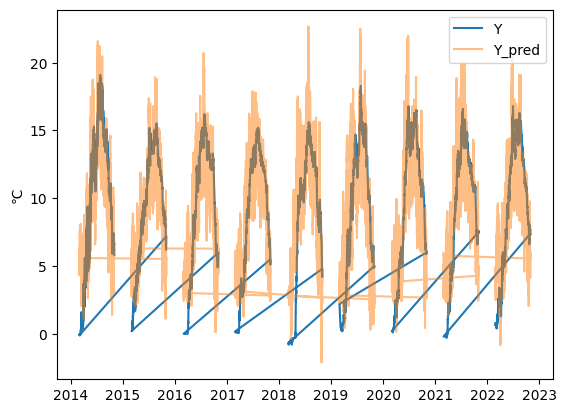

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


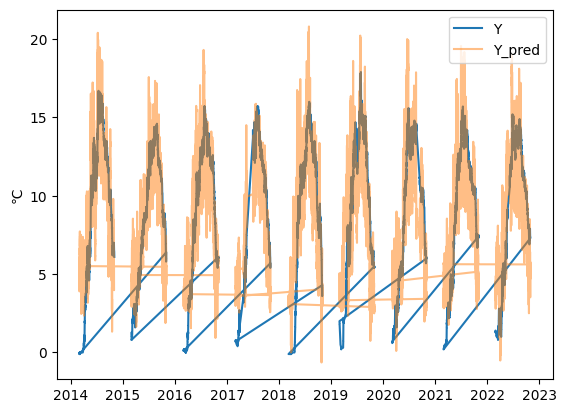

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


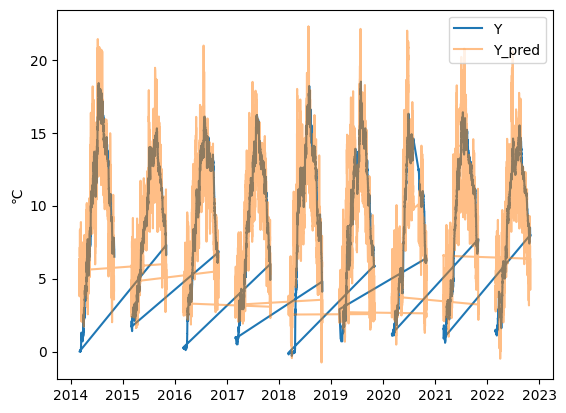

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


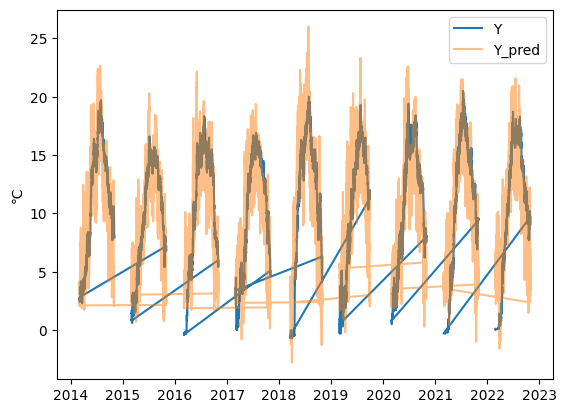

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


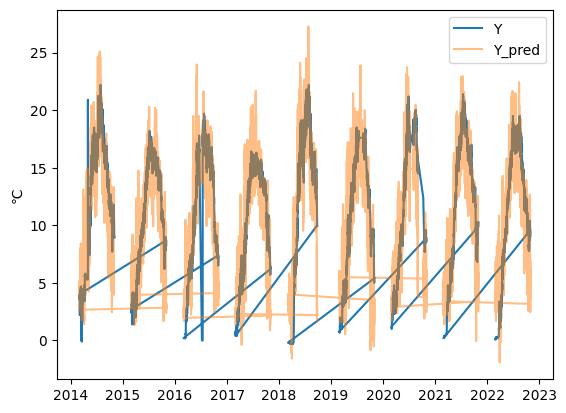

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


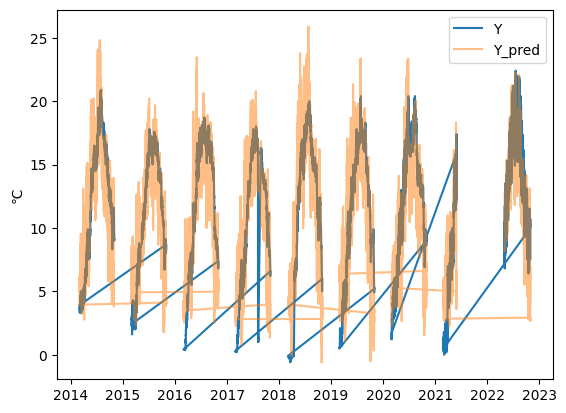

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


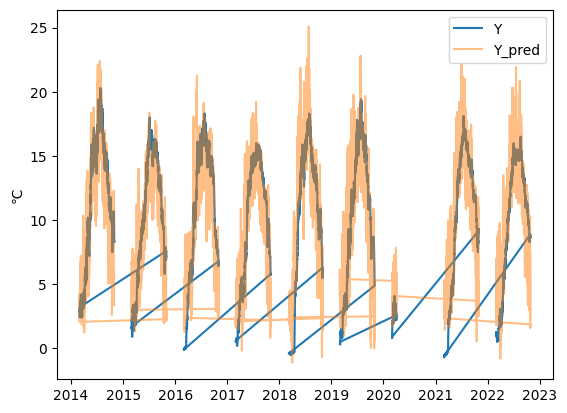

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


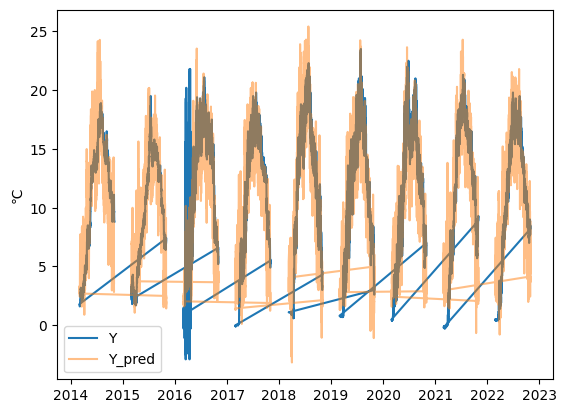

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


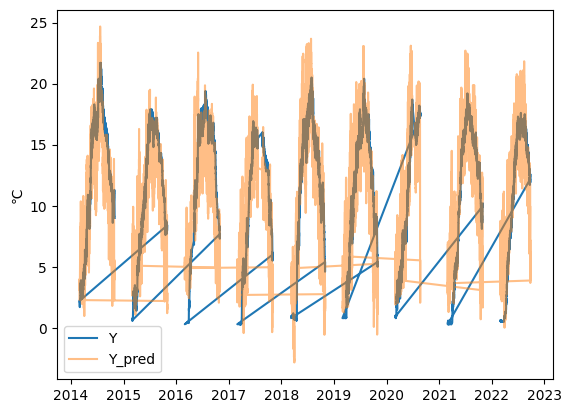

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


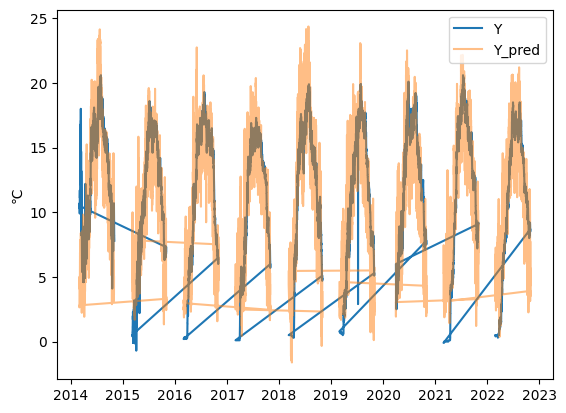

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


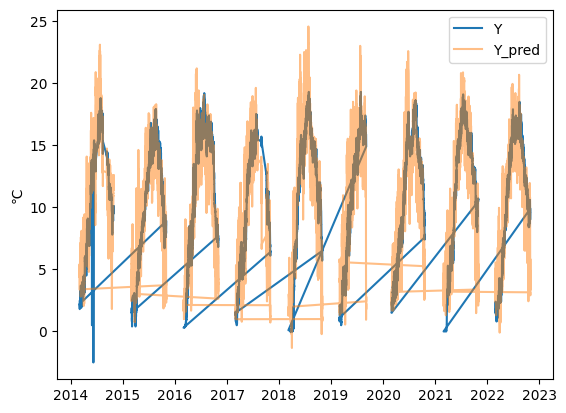

In [8]:
for area in nibio_id:
    score_list_plaugborg = []
    score_list_default = []
    plaugborg_model = LinearRegression(n_jobs = -1)
    default_model = LinearRegression(n_jobs = -1)
    for id in nibio_id[area]:
            mean_df = df[str(id)]#.resample("D").mean()
            mean_df_no_time = mean_df.drop("Time",axis=1)
            data_no_na = mean_df.dropna()
            mean_df_no_time = mean_df_no_time.dropna()

            #air_decom = STL(data_no_na[:,"TM"]).fit()
            #soil_decom = STL(data_no_na[:,"TJM20"]).fit()

            if len(data_no_na) < 2:
                continue

            plaugborg_data = F_plauborg(data_no_na).dropna()

            # X_train, X_test, y_train, y_test = train_test_split(plauborg_data,df[22][2016].loc[:,"TJM10"])
            try:
                scores_plaugborg = cross_validate(plaugborg_model, plaugborg_data, mean_df_no_time.TJM20.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:],
                                        return_estimator=True,
                                        scoring = "neg_root_mean_squared_error",
                                        cv = 6)
                scores_default = cross_validate(default_model, mean_df_no_time.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:,[0,1]], mean_df_no_time.TJM20.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:],
                                        return_estimator=True,
                                        scoring = "neg_root_mean_squared_error",
                                        cv = 6)

            except ValueError as msg:
                print("something wrong: id:" + str(id))
                raise ValueError(msg)
            score_list_plaugborg.append(scores_plaugborg)
            score_list_default.append(scores_default)
            
            max_score_p = np.argmax(scores_plaugborg["test_score"]) # finding the best
            max_score_d = np.argmax(scores_default["test_score"]) # finding the best
            
            plauborg_model = scores_plaugborg["estimator"][max_score_p].fit(plaugborg_data,mean_df_no_time.TJM20.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:])
            default_model = scores_default["estimator"][max_score_d].fit(mean_df_no_time.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:,[0,1]],mean_df_no_time.TJM20.iloc[mean_df_no_time.shape[0]-plaugborg_data.shape[0]:])
            y_pred = plauborg_model.predict(F_plauborg(data_no_na).dropna().loc[50:])
            Y = pd.DataFrame(
                zip(data_no_na.loc[:,"Time"].to_numpy().tolist(), y_pred.flatten()),
                columns=["Time","Y_pred"])
            show_plot([data_no_na.loc[:,["Time","TJM20"]],Y],{1:{"alpha":0.5}} )
            plt.legend(["Jord temperatur 20cm","Jord temperatur 20cm predikert"])
            plt.ylabel("℃")
            plt.show()
    region_score[area] = {"default":np.mean(scores_plaugborg["test_score"]), "plaugborg":np.mean(scores_default["test_score"])}

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import PredictionErrorDisplay
#X, y = load_diabetes(return_X_y=True)
data_t = imputed_nibio_data.flatten()

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexes\base.py:7587: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


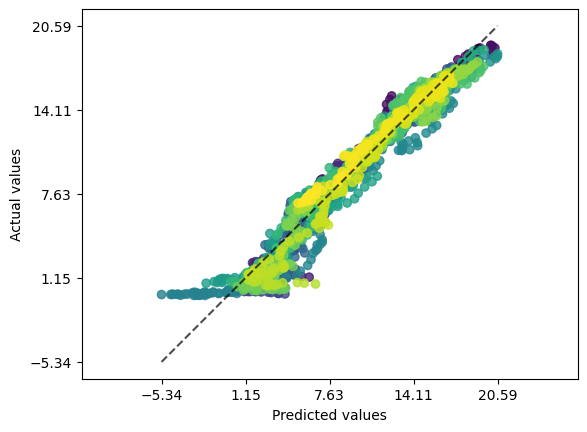

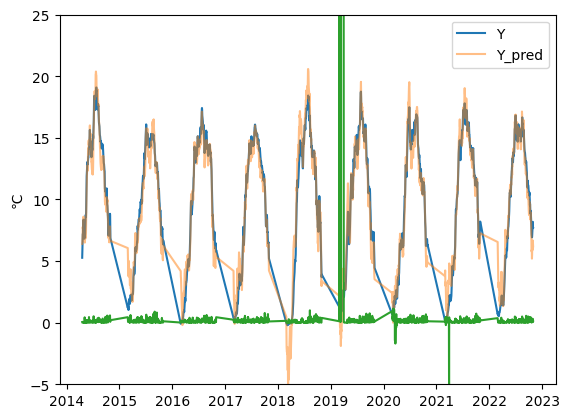

In [10]:
all_data_daily = data_t.set_index("Time").resample("D").mean().dropna().reset_index()

p_data = F_plauborg(all_data_daily)
ridge = LinearRegression().fit(p_data[50:], all_data_daily.iloc[50:,[-1]])
y_pred = ridge.predict(p_data[50:])
display = PredictionErrorDisplay(y_true=all_data_daily.iloc[50:,[-1]], y_pred=y_pred)
display.plot(kind = "actual_vs_predicted",scatter_kwargs = {
    "c": np.linspace(0,1,num = all_data_daily.iloc[50:,[-1]].shape[0]),
    "color": None
})
plt.show()

all_data_daily = all_data_daily.reset_index().loc[50:]

Y = pd.DataFrame(
    zip(all_data_daily["Time"].to_numpy().tolist(), y_pred.flatten()),
    columns=["Time","Y_pred"])

show_plot([all_data_daily.loc[:,["Time","TJM20"]],Y,all_data_daily.loc[:,["Time","RR"]]],{1:{"alpha":0.5}} )
plt.legend(["Y","Y_pred"])
plt.ylim(-5,25)
plt.ylabel("℃")
plt.show()

# ILSTM training

Here we will be training a version of LSTM

In [30]:
import copy

def ILSTM_train(raw_data, target_label,total_epoch = 50,hidden_size=16,lerningrate=1e-3, lead_time=1, seq_length=24, batch_size=16):
    data,scaler,scaler1 = ILSTM.nibio_data_transform(raw_data, target_label)
    data = scaler1.transform(data)

    # TODO: Generate the tensor for lstm model

    [data_x, data_y,data_z] = ILSTM.LSTMDataGenerator(data, lead_time, batch_size, seq_length)

       # concat all variables.
    # TODO: Flexible valid split
    data_train_x=data_x[:int((data_x.shape[0])-400*24)]
    data_train_y = data_y[:int(data_x.shape[0]-400*24)]

    train_data = Data.TensorDataset(data_train_x, data_train_y)
    train_loader = Data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    data_valid_x=data_x[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> trener 35 dager
    data_valid_y=data_y[int(data_x.shape[0]-400*24):int(data_x.shape[0]-365*24)] # -> tester 35 dager
    data_test_x=data_x[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> validerer på resterende
    data_testd_z=data_z[int(data_x.shape[0]-365*24):int(1.0 * data_x.shape[0])] # -> stat på rest

    # TODO: Flexible input shapes and optimizer
    # IMVTensorLSTM,IMVFullLSTM
    model = ILSTM.ILSTM_SV(data_x.shape[2],data_x.shape[1], 1, hidden_size).cuda()
    # TODO: Trian LSTM based on the training and validation sets
    model,predicor_import,temporal_import=ILSTM.train_lstm(model,lerningrate,total_epoch,train_loader,data_valid_x,data_valid_y,"./saved_models/lstm_1d.h5")

    # TODO: Create predictions based on the test sets
    pred, mulit_FV_aten, predicor_import,temporal_import = ILSTM.create_predictions(model, data_test_x,scaler)
    # TODO: Computer score of R2 and RMSE

    data_testd_z=data_testd_z.reshape(-1,1)
    data_testd_z=data_testd_z.cpu()
    data_testd_z=data_testd_z.detach().numpy()
    # Unnormalize
    data_testd_z=scaler.inverse_transform(data_testd_z)
    ILSTM.compute_rmse_r2(data_testd_z,pred,modelname)

    print(pred)
    

Need to transform the data first to fit the model.

In [26]:
def datetime2string(x):
    x["Time"] = x["Time"].apply(lambda y: y.strftime("%Y-%m-%d %X"))
    return x
station_data = imputed_nibio_data.data_transform(datetime2string).merge_layer(level = 1)

In [31]:
ILSTM_train(copy.deepcopy(station_data["11"]),"TJM20",batch_size = 8,total_epoch = 20)

C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (tor

0 tain_Loss: 0.0006527170771732926 validation_Loss: 0.009288888424634933
1 tain_Loss: 0.00021295517217367887 validation_Loss: 0.005685048643499613
2 tain_Loss: 9.34299714572262e-06 validation_Loss: 0.004719177260994911
3 tain_Loss: 1.7839050997281447e-05 validation_Loss: 0.00508963642641902
4 tain_Loss: 2.1484449462150224e-05 validation_Loss: 0.005216263700276613
5 tain_Loss: 3.079278758377768e-05 validation_Loss: 0.0052984911017119884
6 tain_Loss: 3.515339267323725e-05 validation_Loss: 0.005313002038747072
7 tain_Loss: 3.841256693704054e-05 validation_Loss: 0.005322385113686323
8 tain_Loss: 4.288393029128201e-05 validation_Loss: 0.005322808399796486
9 tain_Loss: 4.586366412695497e-05 validation_Loss: 0.005387068726122379
10 tain_Loss: 4.343436739873141e-05 validation_Loss: 0.005386139266192913
11 tain_Loss: 2.8948226827196777e-05 validation_Loss: 0.005369795951992273
12 tain_Loss: 1.9895232981070876e-05 validation_Loss: 0.0053549776785075665
13 tain_Loss: 1.578812771185767e-05 validat

Traceback (most recent call last):
  File "C:\Users\matsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\matsh\AppData\Local\Temp\ipykernel_22516\1875538552.py", line 1, in <module>
    ILSTM_train(copy.deepcopy(station_data["11"]),"TJM20")
  File "C:\Users\matsh\AppData\Local\Temp\ipykernel_22516\1250756675.py", line 33, in ILSTM_train
    model,predicor_import,temporal_import=ILSTM.train_lstm(model,lerningrate,total_epoch,train_loader,data_valid_x,data_valid_y,"./saved_models/lstm_1d.h5")
  File "D:\OneDrive - Norwegian University of Life Sciences\uni\MASTER OPPGAVE\MT24CS\programs\python\ILSTM_Soil_model_main\lstm_interprety_soil_moisture.py", line 169, in train_lstm
    output, mulit_FV_aten, predicor_aten,temporal_aten = model(x)
  File "C:\Users\matsh\AppData\Local\Packages\Pyt

In [24]:
station_data["11"]

,Time,TM,RR,TJM10,TJM20
1570,2022050509,12.7,0.0,14.9,8.1
1571,2022050510,14.0,0.0,12.2,8.1
1572,2022050511,15.4,0.0,11.4,8.1
1573,2022050512,15.4,0.0,11.2,8.1
1574,2022050513,16.1,0.0,11.1,8.2
...,...,...,...,...,...
52915,2014103118,-0.3,0.3,4.5,5.6
52916,2014103119,-0.1,0.2,4.5,5.6
52917,2014103120,0.2,0.4,4.5,5.6
52918,2014103121,0.4,1.0,4.5,5.5
